# Learner algorithm for wh-dependencies, bigrams of container nodes

Loading in the data and the required packages:

In [1]:
import math
import numpy
import pandas as pd
from nltk.util import ngrams
from nltk.probability import FreqDist
from utils import sentence_text, write_file
from learner_functions import get_ngrams, get_freq_dist, get_prob, plot_log_prob_simple

In [2]:
path = "/Users/anastasia/Library/CloudStorage/OneDrive-NTNU/NorGramBank/data/output_wh_corrected_oct23.xlsx"
data = pd.read_excel(path)

In [3]:
data.head(10)

,Sent_id,Graph_id,Web_id,Sentence,All_paths,Chosen_path,Comment
0,s101809,s1574_6_c_4524,1574,Hvor mye hadde den steget siden apachene var her?,"['FOCUS-INT', 'ADJUNCT $ SUBJ']",ADJUNCT,MANUALLY CHECKED
1,s109502,s1831_32_c_3924,1831,– Hvordan visste du det var en tier?,"['FOCUS-INT', 'COMP_nominal FOCUS PREDLINK']",ADJUNCT,MANUALLY CHECKED
2,s111181,s1139_0_c_8287,1139,"Følg nå Arne dit bort, så vil han vise Dem hvo...",['FOCUS-INT'],ADJUNCT,MANUALLY CHECKED
3,s118799,s2112_1_c_4579,2112,«Hvorfor tror du at jeg er så fattig?» spør hun.,"['FOCUS-INT', 'COMP_nominal ADJUNCT $']",ADJUNCT,MANUALLY CHECKED
4,s124862,s1471_4_c_5489,1471,Det er jeg som skal bestemme hva tid barna ska...,['FOCUS-INT'],ADJUNCT,MANUALLY CHECKED
5,s128262,s446_5_c_3702,446,«Hvorfor kjøper du ikke en i tabloidformat?,"['FOCUS-INT', 'ADJUNCT $', 'OBJ -- $']",ADJUNCT,MANUALLY CHECKED
6,s130696,s337_22_c_6374,337,Og hvorfor var det noen som ville det?,"['GVN-TOP_rel COMP_rel ADJUNCT $', 'FOCUS-INT']",ADJUNCT,MANUALLY CHECKED
7,s131533,s1025_3_c_9506,1025,«Hvorfor sa du til pappa at jeg visste at du i...,"['FOCUS-INT', 'COMP_nominal ADJUNCT $']",ADJUNCT,MANUALLY CHECKED
8,s132857,s2349_0_c_4627,2349,Men hvordan visste Henry hvor han skulle finne...,"['FOCUS-INT', 'COMP_wh-int XCOMP ADJUNCT $']",ADJUNCT,MANUALLY CHECKED
9,s143041,s553_2_c_3419,553,– Hvordan visste du at vi var her?,"['FOCUS-INT', 'COMP_nominal PREDLINK']",ADJUNCT,MANUALLY CHECKED


## We start by exploring the input data for the learner by calculating:
- the total number of dependencies
- unique f-structure labels
- certain dependency counts etc.

In [4]:
data["Chosen_path"].describe()  # To see the number of filler-gap paths, how many of them are unique etc.

count       19004
unique         51
top       ADJUNCT
freq         5800
Name: Chosen_path, dtype: object

In [5]:
unique = data["Chosen_path"].unique()  # Another way to find unique paths
len(unique)

51

In [6]:
unique  # All of the possible paths

array(['ADJUNCT', 'ADJUNCT XCOMP', 'COMP_inf ADJUNCT',
       'COMP_nominal ADJUNCT', 'COMP_nominal ADJUNCT OBJ',
       'COMP_nominal OBJ', 'COMP_nominal OBL-TH', 'COMP_nominal PREDLINK',
       'COMP_nominal XCOMP ADJUNCT', 'COMP_nominal XCOMP OBJ',
       'COMP_nominal XCOMP OBL-TH', 'COMP_nominal XCOMP PREDLINK',
       'COMP_nominal XCOMP SUBJ', 'COMP_nominal XCOMP XCOMP OBJ', 'OBJ',
       'OBJ COMP_inf OBJ', 'OBL-TH', 'PREDLINK', 'PREDLINK ADJUNCT',
       'PREDLINK ADJUNCT OBJ', 'PREDLINK COMP_inf OBJ', 'SUBJ',
       'XCOMP  ADJUNCT', 'XCOMP ADJUNCT', 'XCOMP ADJUNCT OBJ',
       'XCOMP COMP_nominal OBJ', 'XCOMP COMP_nominal XCOMP OBJ',
       'XCOMP COMP_nominal XCOMP PREDLINK', 'XCOMP OBJ', 'XCOMP OBL-TH',
       'XCOMP PREDLINK', 'XCOMP SUBJ', 'XCOMP XCOMP ADJUNCT',
       'XCOMP XCOMP OBJ', 'XCOMP XCOMP SUBJ', 'XCOMP XCOMP XCOMP OBJ',
       'ADJUNCT OBJ', 'OBJ OBL-TH', 'PREDLINK ADJUNCT SUBJ',
       'PREDLINK OBJ', 'PREDLINK OBL-TH', 'PREDLINK XCOMP OBJ',
       'XCOMP OB

In [7]:
# Short dependencies consisting of one label 
i = 0
for p in data["Chosen_path"]:
    if " " not in p:
        i+=1
i/len(data["Chosen_path"])*100  # Percentage of one-label paths

74.8474005472532

In [8]:
# All f-structure labels
labels_set = set()
for string in data['Chosen_path']:
    seq = str(string).split()
    for label in seq:
        labels_set.add(label)
len(labels_set)  # Number of unique labels

10

In [9]:
labels_set

{'ADJUNCT',
 'COMP_inf',
 'COMP_nominal',
 'OBJ',
 'OBJ-BEN',
 'OBL-AG',
 'OBL-TH',
 'PREDLINK',
 'SUBJ',
 'XCOMP'}

In [10]:
counts = data["Chosen_path"].value_counts()
paths_to_get_counts_for = ["SUBJ", "OBJ", "PREDLINK", # Short dependencies
                           "COMP_nominal SUBJ", "COMP_nominal OBJ", # Dependencies into embedded declaratives
                           "COMP_wh-int SUBJ", "COMP_wh-int OBJ", # Dependencies into embedded interrogative questions
                           "COMP_pol-int SUBJ", "COMP_pol-int OBJ"] # Dependencies into embedded polar questions

In [11]:
for path in paths_to_get_counts_for:
    try:
        print(path, counts[path])
    except KeyError:
        print(path, "No examples of such dependency found")

SUBJ 1493
OBJ 2623
PREDLINK 3930
COMP_nominal SUBJ No examples of such dependency found
COMP_nominal OBJ 32
COMP_wh-int SUBJ No examples of such dependency found
COMP_wh-int OBJ No examples of such dependency found
COMP_pol-int SUBJ No examples of such dependency found
COMP_pol-int OBJ No examples of such dependency found


## Now we split the input data for into n-grams and calculate the frequency distribution:

In [12]:
# Set n-gram window size
n_gram = 2

In [13]:
all_ngrams = []
for string in data['Chosen_path']:
    seq = str(string).split()
    n_grams = get_ngrams(seq, n_gram)
    for ngr in n_grams:
        all_ngrams.append(ngr)
                
freq_dist = get_freq_dist(all_ngrams)
print('20 most common container node n-grams:')
for i in freq_dist.most_common(20):
    print(i)

20 most common container node n-grams:
(('ADJUNCT', 'end'), 7096)
(('start', 'ADJUNCT'), 6144)
(('OBJ', 'end'), 4939)
(('PREDLINK', 'end'), 4257)
(('start', 'XCOMP'), 4179)
(('start', 'PREDLINK'), 4058)
(('start', 'OBJ'), 2629)
(('SUBJ', 'end'), 2167)
(('XCOMP', 'OBJ'), 1760)
(('start', 'SUBJ'), 1493)
(('XCOMP', 'ADJUNCT'), 1331)
(('XCOMP', 'SUBJ'), 673)
(('OBL-TH', 'end'), 529)
(('ADJUNCT', 'OBJ'), 490)
(('start', 'OBL-TH'), 373)
(('XCOMP', 'PREDLINK'), 330)
(('XCOMP', 'XCOMP'), 269)
(('XCOMP', 'OBL-TH'), 126)
(('start', 'COMP_nominal'), 122)
(('PREDLINK', 'ADJUNCT'), 93)


## Now we start exploring the modeling results by island type
### 1. Subject island

Plotting the modelled probabilities for four experimental conditions from the Sprouse's design

In [14]:
# get_prob returns the probability for a path, the path itself, and a list of unattested n-grams
p_short_1, path1, un1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'SUBJ', 'end'] -6.362139588974416 



In [15]:
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['COMP_nominal', 'SUBJ', 'ADJUNCT', 'OBJ'], freq_dist, n_gram)  # long island

['start', 'COMP_nominal', 'SUBJ', 'end'] -20.232226844848384 

['start', 'COMP_nominal', 'SUBJ', 'ADJUNCT', 'OBJ', 'end'] -35.258605999858354 



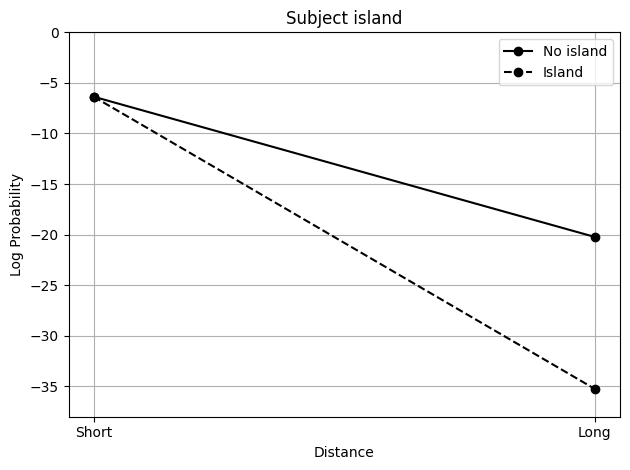

In [16]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Subject island")

In [17]:
condition = []
paths = [" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)]
probs = [p_short_1, p_short_2, p_long_1, p_long_2]
unattested = [un1, un2, un3, un4]
condition.extend(["Subject"]*4)

In [18]:
unattested

[[],
 [],
 [('COMP_nominal', 'SUBJ')],
 [('COMP_nominal', 'SUBJ'), ('SUBJ', 'ADJUNCT')]]

### 2. CNP island (reported in the Appendix)

In [19]:
# Short conditions are the same as previously
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['OBJ', 'COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long island

['start', 'COMP_nominal', 'OBJ', 'end'] -15.203844543627584 

['start', 'OBJ', 'COMP_nominal', 'OBJ', 'end'] -23.50672722878555 



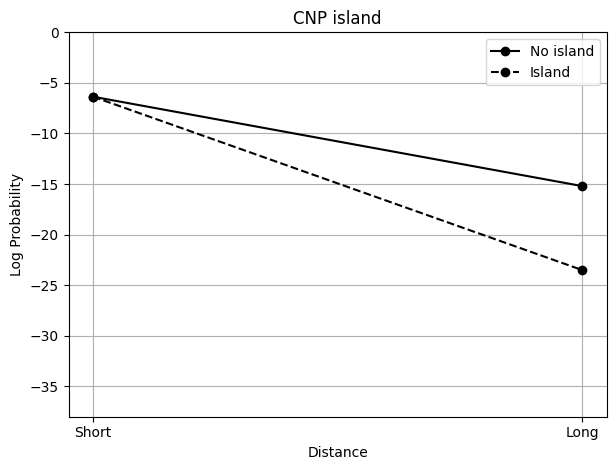

In [20]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "CNP island")

In [21]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["CNP"]*4)

### 3. EQ island (comp_wh-int), subject extraction

In [22]:
# Short conditions as defined previously
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['COMP_wh-int', 'SUBJ'], freq_dist, n_gram)  # long island

['start', 'COMP_nominal', 'SUBJ', 'end'] -20.232226844848384 

['start', 'COMP_wh-int', 'SUBJ', 'end'] -25.73348505539311 



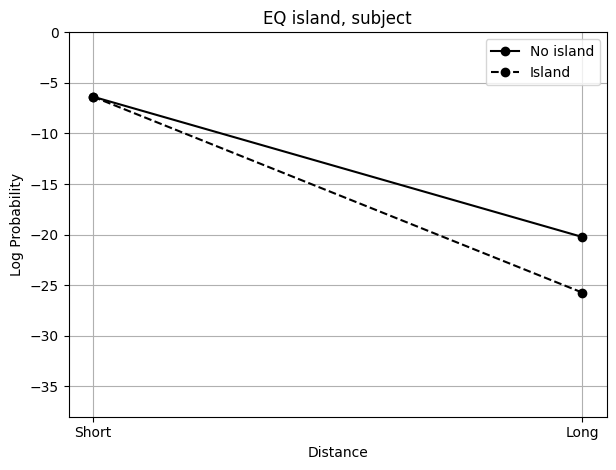

In [23]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "EQ island, subject")

In [24]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["EQ"]*4)

### 4. EQ island (comp_wh-int), object extraction (reported in the Appendix)

In [25]:
p_short_1, path1, un1 = get_prob(['OBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['OBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['COMP_wh-int', 'OBJ'], freq_dist, n_gram)  # long island

['start', 'OBJ', 'end'] -4.972778551771349 

['start', 'OBJ', 'end'] -4.972778551771349 

['start', 'COMP_nominal', 'OBJ', 'end'] -15.203844543627584 

['start', 'COMP_wh-int', 'OBJ', 'end'] -24.909795373563277 



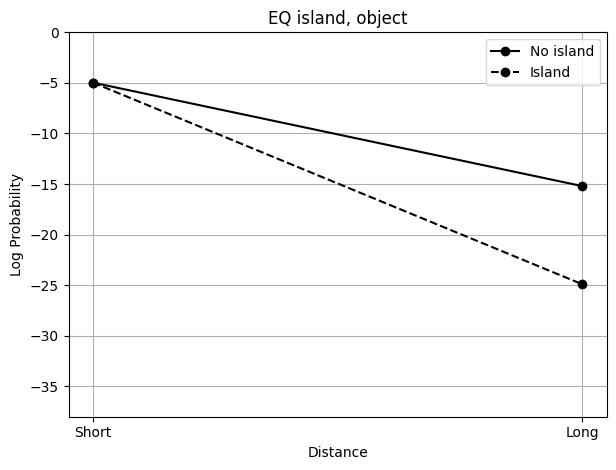

In [26]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "EQ island, object")

In [27]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["EQ-object"]*4)

### 5. Whether island (comp_pol-int), subject extraction (reported in the Appendix)

In [28]:
p_short_1, path1, un1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['COMP_pol-int', 'SUBJ'], freq_dist, n_gram)  # long island

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'COMP_nominal', 'SUBJ', 'end'] -20.232226844848384 

['start', 'COMP_pol-int', 'SUBJ', 'end'] -25.73348505539311 



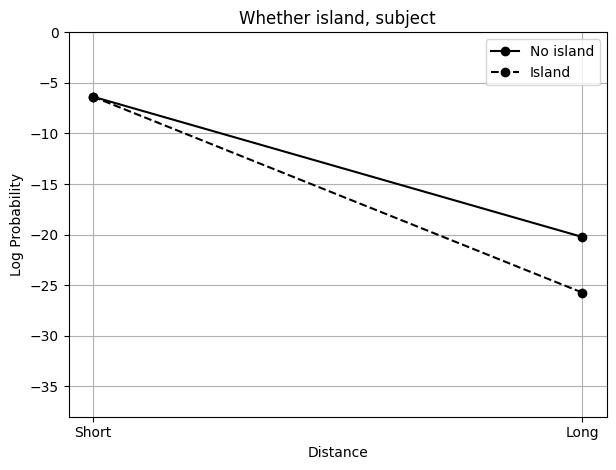

In [29]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Whether island, subject")

In [30]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["Whether-subject"]*4)

### 6. Whether island (comp_pol-int), object extraction (reported in the Appendix)

In [31]:
p_short_1, path1, un1 = get_prob(['OBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['OBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['COMP_pol-int', 'OBJ'], freq_dist, n_gram)  # long island

['start', 'OBJ', 'end'] -4.972778551771349 

['start', 'OBJ', 'end'] -4.972778551771349 

['start', 'COMP_nominal', 'OBJ', 'end'] -15.203844543627584 

['start', 'COMP_pol-int', 'OBJ', 'end'] -24.909795373563277 



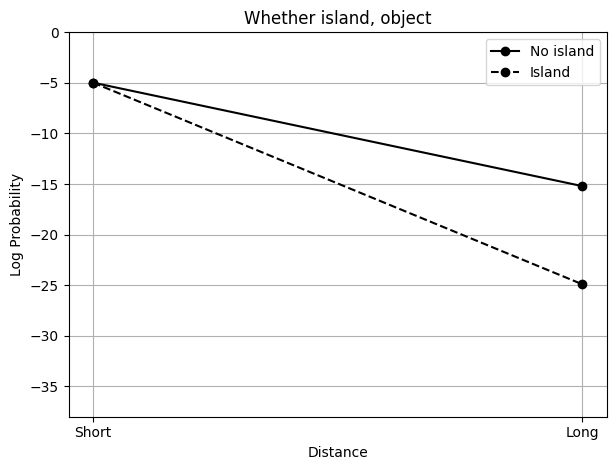

In [32]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Whether island, object")

In [33]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["Whether-object"]*4)

### 7. Adjunct island

In [34]:
p_short_1, path1, un1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['ADJUNCT_adv', 'OBJ'], freq_dist, n_gram)  # long island

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'COMP_nominal', 'OBJ', 'end'] -15.203844543627584 

['start', 'ADJUNCT_adv', 'OBJ', 'end'] -24.909795373563277 



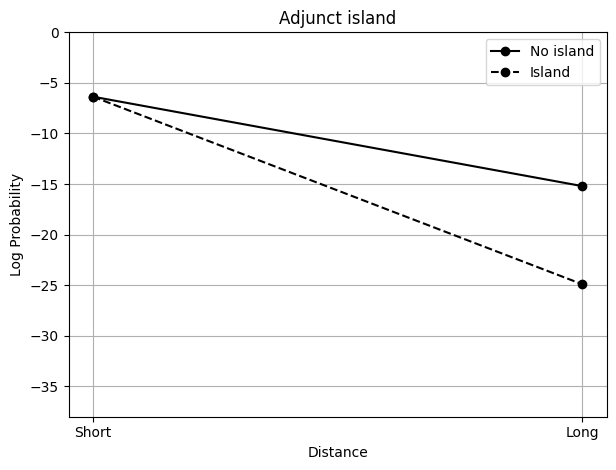

In [35]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "Adjunct island")

In [36]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["Adjunct"]*4)

### 8. RC island, object extraction, predlink as comparison

In [37]:
p_short_1, path1, un1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['PREDLINK'], freq_dist, n_gram)  # short island
p_long_2, path4, un4 = get_prob(['ADJUNCT_rel', 'OBJ'], freq_dist, n_gram)  # long island

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'PREDLINK', 'end'] -4.687340796547203 

['start', 'ADJUNCT_rel', 'OBJ', 'end'] -24.909795373563277 



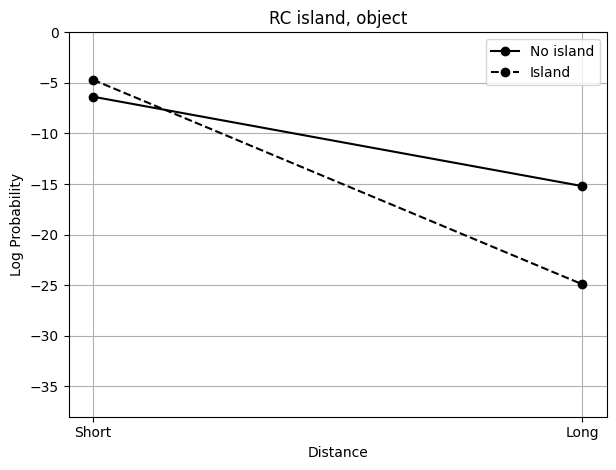

In [38]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "RC island, object")

In [39]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["RC-predlink"]*4)

### 9. RC island, subject extraction, subj as comparison

In [40]:
p_short_1, path1, un1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'SUBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['ADJUNCT_rel', 'SUBJ'], freq_dist, n_gram)  # long island

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'COMP_nominal', 'SUBJ', 'end'] -20.232226844848384 

['start', 'ADJUNCT_rel', 'SUBJ', 'end'] -25.73348505539311 



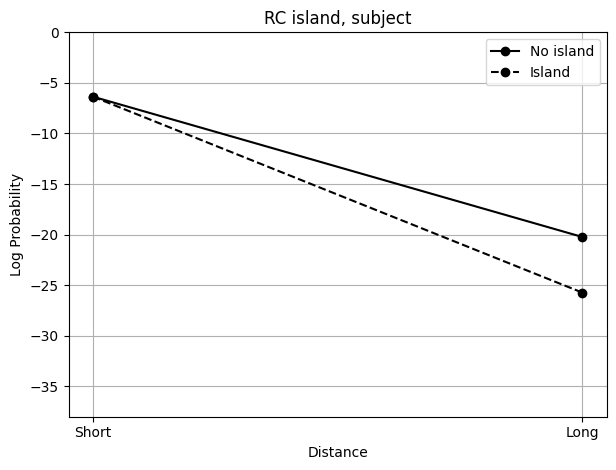

In [41]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "RC island, subject")

In [42]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["RC-subject"]*4)

## 10. RC island, P-comp extraction

In [45]:
p_short_1, path1, un1 = get_prob(['SUBJ'], freq_dist, n_gram)  # short no island
p_short_2, path2, un2 = get_prob(['SUBJ'], freq_dist, n_gram)  # short island
p_long_1, path3, un3 = get_prob(['COMP_nominal', 'ADJUNCT', 'OBJ'], freq_dist, n_gram)  # long no island
p_long_2, path4, un4 = get_prob(['ADJUNCT_rel', 'ADJUNCT', 'OBJ'], freq_dist, n_gram)  # long island

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'SUBJ', 'end'] -6.362139588974416 

['start', 'COMP_nominal', 'ADJUNCT', 'OBJ', 'end'] -20.225723705526125 

['start', 'ADJUNCT_rel', 'ADJUNCT', 'OBJ', 'end'] -29.3905435622005 



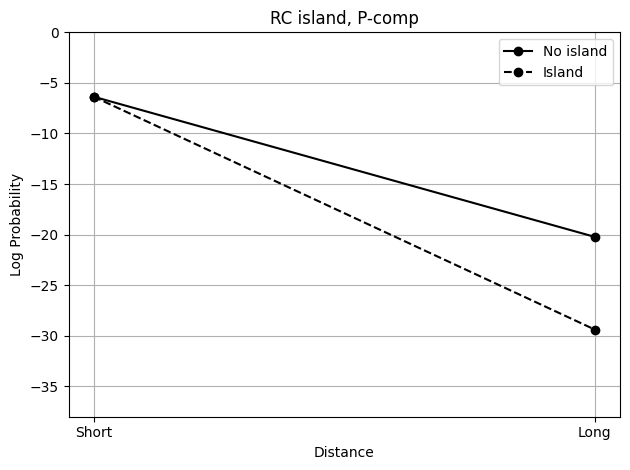

In [46]:
plot_log_prob_simple(p_short_1, p_long_1, p_short_2, p_long_2, title = "RC island, P-comp")

In [47]:
paths.extend([" ".join(path1), " ".join(path2), " ".join(path3), " ".join(path4)])
probs.extend([p_short_1, p_short_2, p_long_1, p_long_2])
unattested.extend([un1, un2, un3, un4])
condition.extend(["RC-Pcomp"]*4)

In [48]:
structure = ["noIsland", "Island", "noIsland", "Island"]*10

In [49]:
distance = ["Short", "Short", "Long", "Long"]*10

In [50]:
dependency = ["Wh"]*40
n_gram = ["Bigram"]*40

In [51]:
df = pd.DataFrame(list(zip(condition, distance, structure, paths, probs, unattested, dependency, n_gram)),
               columns =['condition', 'distance', 'structure', 'path', 'log_probability', 
                         'unattested_ngrams', 'dependency', 'n_gram'])

In [52]:
df.to_csv('/Users/anastasia/Library/CloudStorage/OneDrive-NTNU/Project_R_files/ps-learner/data/model_results_wh_bigrams.csv', index=False)

In [53]:
# All bigrams and their frequency
for key,value in sorted(freq_dist.items()):
    print(key,value)

('ADJUNCT', 'OBJ') 490
('ADJUNCT', 'SUBJ') 1
('ADJUNCT', 'XCOMP') 1
('ADJUNCT', 'end') 7096
('COMP_inf', 'ADJUNCT') 1
('COMP_inf', 'OBJ') 3
('COMP_nominal', 'ADJUNCT') 19
('COMP_nominal', 'OBJ') 33
('COMP_nominal', 'OBL-TH') 2
('COMP_nominal', 'PREDLINK') 18
('COMP_nominal', 'XCOMP') 55
('OBJ', 'COMP_inf') 1
('OBJ', 'OBL-TH') 5
('OBJ', 'end') 4939
('OBJ-BEN', 'end') 10
('OBL-AG', 'end') 5
('OBL-TH', 'end') 529
('PREDLINK', 'ADJUNCT') 93
('PREDLINK', 'COMP_inf') 2
('PREDLINK', 'OBJ') 30
('PREDLINK', 'OBL-TH') 23
('PREDLINK', 'XCOMP') 1
('PREDLINK', 'end') 4257
('SUBJ', 'end') 2167
('XCOMP', 'ADJUNCT') 1331
('XCOMP', 'COMP_nominal') 5
('XCOMP', 'OBJ') 1760
('XCOMP', 'OBJ-BEN') 5
('XCOMP', 'OBL-AG') 5
('XCOMP', 'OBL-TH') 126
('XCOMP', 'PREDLINK') 330
('XCOMP', 'SUBJ') 673
('XCOMP', 'XCOMP') 269
('XCOMP', 'end') 1
('start', 'ADJUNCT') 6144
('start', 'COMP_inf') 1
('start', 'COMP_nominal') 122
('start', 'OBJ') 2629
('start', 'OBJ-BEN') 5
('start', 'OBL-TH') 373
('start', 'PREDLINK') 4058
('